Best heuristic energy is -1433.4906005859375
Best heuristic name: MERZ1999GLS
Quantum annealing energy wo sampling is -1433.3739324388655
Edges_number: 1500
Layers number: 3200
Mismatching nodes number: 13
Cut size: 158
Parts sizes: 556, 444
Min bond dimension: 577.334368968788


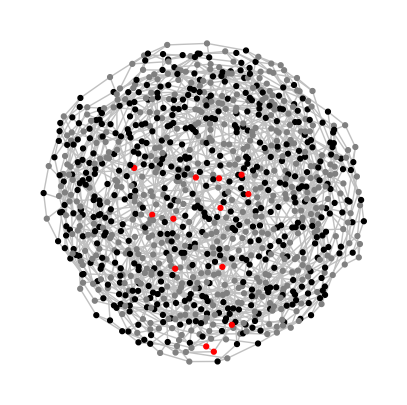

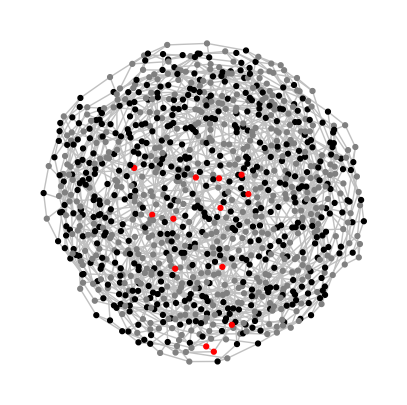

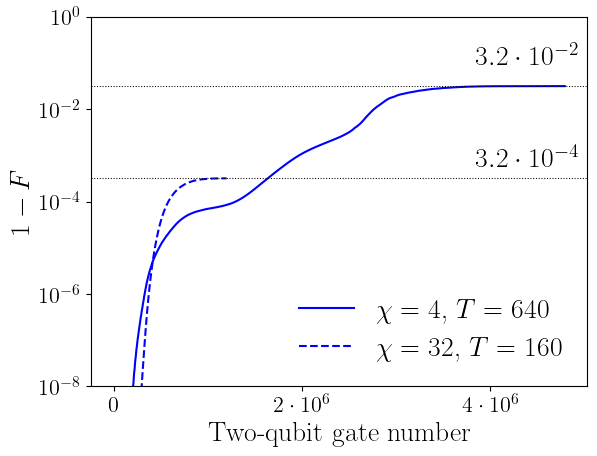

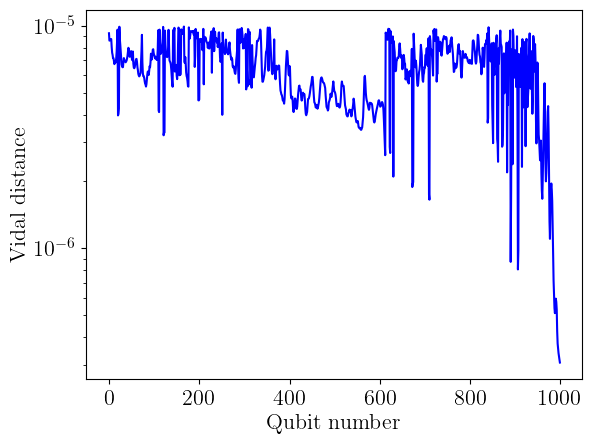

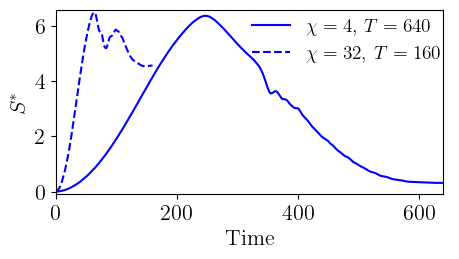

In [1]:
import os
from math import floor, log10
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import h5py
import numpy as np
import networkx as nx
import yaml
from numpy.typing import NDArray
from sklearn.cluster import SpectralClustering

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Ariel",
    "font.size": 16,
})
upcolor="black"
downcolor="grey"
mismatch_color="red"

def fexp(f):
    return int(floor(log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

def get_adj_matrix(
    nodes_number: int,
    pairs: NDArray,
) -> NDArray:
    adj_matrix = np.zeros((nodes_number, nodes_number), dtype=np.float64)
    for pair in pairs:
        adj_matrix[pair[0], pair[1]] = 1
        adj_matrix[pair[1], pair[0]] = 1
    return adj_matrix

def infidelity(single_gate_errors: NDArray) -> NDArray:
    return 1. - ((1. - single_gate_errors ** 2) ** 2).cumprod()

script_dir = os.getcwd()
# ---------- here is the path to the results directory ----------------------
# here is the path to the results directory
# ---------------------------------------------------------------------------
results_dir_path1 = f"{script_dir}/outputs/qbp/very_large/2024-05-18/11-00-16"
results_dir_path2 = f"{script_dir}/outputs/qbp/very_large/2024-05-12/10-12-21"
results_path1 = f"{results_dir_path1}/result"
results_path2 = f"{results_dir_path2}/result"
heuristics_results_path1 = f"{results_dir_path1}/mqlib_result"
config_path1 = f"{results_dir_path1}/.hydra/config.yaml"
config_path2 = f"{results_dir_path2}/.hydra/config.yaml"
with open(config_path1, "r") as f:
    raw_config = f.read()
    config = yaml.safe_load(raw_config)
sample_measurements1 = bool(config["quantum_annealing_schedule"]["sample_measurements"])
layers_number1 = int(config["quantum_annealing_schedule"]["steps_number"])
time_step1 = float(config["quantum_annealing_schedule"]["total_time_step_size"])
chi1 = int(config["emulator_parameters"]["max_chi"])
time1 = np.arange(layers_number1) * time_step1
with open(config_path2, "r") as f:
    raw_config = f.read()
    config = yaml.safe_load(raw_config)
sample_measurements2 = bool(config["quantum_annealing_schedule"]["sample_measurements"])
layers_number2 = int(config["quantum_annealing_schedule"]["steps_number"])
time_step2 = float(config["quantum_annealing_schedule"]["total_time_step_size"])
chi2 = int(config["emulator_parameters"]["max_chi"])
time2 = np.arange(layers_number2) * time_step2
best_heuristic_energy = 1e10
best_heuristic_name = None
best_heuristic_configuration = None
with h5py.File(heuristics_results_path1, "r") as f:
    for key in f.keys():
        if "energy" in key:
            energy = np.array(f[key])
            if energy < best_heuristic_energy:
                best_heuristic_energy = energy
                best_heuristic_name = key.split("_")[0]
                best_heuristic_configuration = np.array(f[f"{best_heuristic_name}_configuration"])
best_heuristic_color = list(map(lambda x: downcolor if x > 0.5 else upcolor, np.array(best_heuristic_configuration)))
with h5py.File(results_path2, "r") as f:
    truncation_errors2 = np.array(f["truncation_errors"])
    pairs = np.array(f["coupled_spin_pairs"])
    edges_number = pairs.shape[0]
    entropies2 = np.array(f["entropies"])
    entropies2 = entropies2.reshape((-1, edges_number))
with h5py.File(results_path1, "r") as f:
    circuit = nx.Graph()
    fields = np.array(f["fields"])
    pairs = np.array(f["coupled_spin_pairs"])
    nodes_number = fields.shape[0]
    edges_number = pairs.shape[0]
    coupling_amplitudes = np.array(f["coupling_amplitudes"])
    truncation_errors1 = np.array(f["truncation_errors"])
    entropies1 = np.array(f["entropies"])
    entropies1 = entropies1.reshape((-1, edges_number))
    mismatching_nodes_number = 0
    quantum_annealing_color_wo_sampling = list(map(lambda x: downcolor if x > 0.5 else upcolor, np.array(f["density_matrices"])[:, 0, 0]))
    quantum_annealer_energy_wo_sampling =  np.array(f["quantum_annealer_energy_wo_sampling"])
    if sample_measurements1:
        quantum_annealer_coloring = list(map(lambda x: downcolor if x > 0.5 else upcolor, np.array(f["quantum_annealer_configuration"])))
        quantum_annealer_energy = np.array(f["quantum_annealer_energy"])
    for i in range(len(quantum_annealing_color_wo_sampling)):
        if quantum_annealing_color_wo_sampling[i] != best_heuristic_color[i]:
            quantum_annealing_color_wo_sampling[i] = mismatch_color
            best_heuristic_color[i] = mismatch_color
            mismatching_nodes_number += 1
    vidal_distances_after_regauging = np.array(f["vidal_distances_after_regauging"])
    for id in range(fields.shape[0]):
        circuit.add_node(id)
    for pair in pairs:
        circuit.add_edge(pair[0], pair[1])
    print(f"Best heuristic energy is {best_heuristic_energy}")
    print(f"Best heuristic name: {best_heuristic_name}")
    fig_graph_best_heuristic, ax = plt.subplots(1, 1, figsize=(5, 5))
    #ax.set_title(r"${\rm " + best_heuristic_name + r"}$")
    nx.draw_kamada_kawai(circuit, node_size=12, width=1., edge_color='silver', node_color=best_heuristic_color, ax=ax)
    fig_graph_wo_sampling, ax = plt.subplots(1, 1, figsize=(5, 5))
    #ax.set_title(r"${\rm Quantum \ Annealing}$")
    print(f"Quantum annealing energy wo sampling is {quantum_annealer_energy_wo_sampling}")
    nx.draw_kamada_kawai(circuit, node_size=12, width=1., edge_color='silver', node_color=quantum_annealing_color_wo_sampling, ax=ax)
    if sample_measurements1:
        fig_graph_with_sampling, ax = plt.subplots(1, 1, figsize=(5, 5))
        print(f"Quantum annealing energy with sampling is {quantum_annealer_energy}")
        nx.draw_kamada_kawai(circuit, node_size=8, width=1., edge_color='silver', node_color=quantum_annealer_coloring, ax=ax)
    fig_truncation_error, ax = plt.subplots(1, 1)
    infid1 = infidelity(truncation_errors1)
    max_infid1 = np.max(infid1)
    infid2 = infidelity(truncation_errors2)
    max_infid2 = np.max(infid2)
    ax.plot(infid1, 'b', label=r"$\chi=" + f"{chi1}" + r"$, " + r"$T=" + f"{int(time1[-1] + time_step1)}" + r"$")
    ax.plot(infid2, 'b--', label=r"$\chi=" + f"{chi2}" + r"$, " + r"$T=" + f"{int(time2[-1] + time_step2)}" + r"$")
    ax.axhline(max_infid1, color='k', linewidth=0.75, linestyle="dotted")
    ax.axhline(max_infid2, color='k', linewidth=0.75, linestyle="dotted")
    trans = transforms.blended_transform_factory(
        ax.get_yticklabels()[0].get_transform(), ax.transData,
    )
    ax.text(1, max_infid1 + 0.1, r"$" + "{:.2}".format(fman(max_infid1)) + r"\cdot 10^{" + f"{fexp(max_infid1)}" +r"}" + r"$", transform=trans,
        ha="right", va="center", fontsize=20)
    ax.text(1, max_infid2 + 5e-4, r"$" + "{:.2}".format(fman(max_infid2)) + r"\cdot 10^{" + f"{fexp(max_infid2)}" +r"}" + r"$", transform=trans,
        ha="right", va="center", fontsize=20)
    ax.set_ylabel(r"$1 - F$", fontsize=20)
    ax.set_ylim([1e-8, 1])
    ax.set_xlabel("Two-qubit gate number", fontsize=20)
    ax.set_xticks([0, 2000000, 4000000])
    ax.set_xticklabels([r"$0$", r"$2\cdot 10^6$", r"$4 \cdot 10^6$"])
    ax.set_yscale('log')
    ax.legend(frameon=False, fontsize=20)
    fig_vidal_dist, ax = plt.subplots(1, 1)
    ax.plot(vidal_distances_after_regauging[-nodes_number:], 'b')
    ax.set_yscale("log")
    ax.set_ylabel("Vidal distance")
    ax.set_xlabel("Qubit number")
    fig_entropy, ax = plt.subplots(1, 1, figsize=(5., 2.4))
    sc = SpectralClustering(
        affinity='precomputed',
        random_state=0,
        n_clusters=2,
    )
    adj_matrix = get_adj_matrix(nodes_number, pairs)
    clustering = sc.fit(adj_matrix).labels_
    cut_entropy1 = np.zeros((entropies1.shape[0],))
    cut_size = 0
    for pair, entropy in zip(pairs, entropies1.T):
        if clustering[pair[0]] != clustering[pair[1]]:
            cut_entropy1 += entropy
            cut_size += 1
    cut_entropy2 = np.zeros((entropies2.shape[0],))
    cut_size = 0
    for pair, entropy in zip(pairs, entropies2.T):
        if clustering[pair[0]] != clustering[pair[1]]:
            cut_entropy2 += entropy
            cut_size += 1
    ax.plot(time1, cut_entropy1, 'b', label=r"$\chi=" + f"{chi1}" + r"$, " + r"$T=" + f"{int(time1[-1] + time_step1)}" + r"$")
    ax.plot(time2, cut_entropy2, 'b--', label=r"$\chi=" + f"{chi2}" + r"$, " + r"$T=" + f"{int(time2[-1] + time_step2)}" + r"$")
    ax.set_ylabel(r"$S^*$")
    ax.set_xlabel("Time")
    ax.set_xlim(left=0, right=640)
    ax.set_ylim(bottom=-0.1, top=np.max(cut_entropy2) + 0.1)
    ax.legend(frameon=False, fontsize=14, loc=(0.485, 0.67))
    print(f"Edges_number: {edges_number}")
    print(f"Layers number: {layers_number1}")
    print(f"Mismatching nodes number: {mismatching_nodes_number}")
    print(f"Cut size: {cut_size}")
    print(f"Parts sizes: {clustering.sum()}, {nodes_number - clustering.sum()}")
    print(f"Min bond dimension: {np.exp(np.max(cut_entropy1))}")

In [15]:
fig_graph_best_heuristic.savefig(f"{results_dir_path1}/best_heuristic_graph.pdf", bbox_inches="tight")
fig_graph_wo_sampling.savefig(f"{results_dir_path1}/qbp_graph_wo_sampling.pdf", bbox_inches="tight")
fig_truncation_error.savefig(f"{results_dir_path1}/qbp_infidelity.pdf", bbox_inches="tight")
fig_vidal_dist.savefig(f"{results_dir_path1}/qbp_vidal_distance.pdf", bbox_inches="tight")
fig_entropy.savefig(f"{results_dir_path1}/qbp_entropy.pdf", bbox_inches="tight")
if sample_measurements1:
    fig_graph_with_sampling.savefig(f"{results_dir_path1}/qbp_graph_with_sampling.pdf", bbox_inches="tight")